# Add model 3, which is keeping the number of producers and also the number of  movies|

In [1]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ks_2samp
from operator import itemgetter

src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir,'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.shift_graph_maker as sgm
import network.network_generator as net_gen

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Reading data

In [3]:
movie_producer_df = net_gen.open_movie_data()

Loaded IMDb movies producing_gender_percentage
Got all_movies


# Building synthetic networks


* fixed values
    * number of movies per year
    * number of producers per year

* variables
    * number of people per team - producer_num_list *
    * number of movies per producer - occurence_list *
    * size of gaps - gap_list


In [4]:
unlistyfied_producer_df = net_gen.unlistify(movie_producer_df, 'producers')

In [5]:
#number of movies per producer of the 90s
unlistyfied_producer_df['producer_id'] = unlistyfied_producer_df.producers.apply(lambda x: x[0])

In [6]:
movies_per_producer = unlistyfied_producer_df.groupby('producer_id').count()['_id']

# Model 3

fixed number of movies, fixed number of producers
given number of movies per producer
given size of gaps per producer/movie

## Model 3- 0

fixed number of movies, fixed number of producers

team size round down/up of the mean

In [7]:
movie_list = net_gen.bootstrap(movies_per_producer, len(movies_per_producer))

In [8]:
total_num_producers = len(list(set([i[0] for i in unlistyfied_producer_df.producers.tolist()])))

## Assign genders

In [9]:
gender_df = support.get_staff_df('producers')[['_id', 'female_count', 'first_movie', 'last_movie', 'gender']]

In [10]:
females = sgm.generate_gender_seeds(gender_df)

In [11]:
original_producer_list = [i[0] for sublist in movie_producer_df.producers.tolist() for i in sublist]
seeds = [i for i in females if i in original_producer_list]
len(seeds)

1064

In [12]:
gender_df = support.get_staff_df('producers')[['_id', 'female_count', 'first_movie', 'last_movie', 'gender']]

In [13]:
unlistyfied_producer_df['gender'] = unlistyfied_producer_df.apply(net_gen.assign_gender, args=(gender_df,), axis=1)

In [14]:
movie_per_producer_gender = {}
for g, g_df in unlistyfied_producer_df.groupby('gender'):
    movies_per_producer = g_df.groupby('producer_id').count()['_id'].tolist()
    movie_per_producer_gender[g] = movies_per_producer

In [15]:
movies = []
for p, group in unlistyfied_producer_df.groupby('producer_id'):
    group_sorted = group.sort_values('year')
    diff = group_sorted.year.diff().values
    if len(group_sorted) > 40:
        print(len(group_sorted))
        print(p)
#         print(group_sorted.year.tolist())
        diff_ratio = Counter(diff[~np.isnan(diff)])
        diffs, occur = zip(*diff_ratio.items())
        diffs = np.array(diffs)
        occur = np.array(occur)
        print(diffs)
        print(occur/sum(occur))
        movies.append(group_sorted.producers.tolist())

43
nm0005544
[3. 0. 1.]
[0.02380952 0.83333333 0.14285714]
43
nm0918424
[3. 0. 1.]
[0.02380952 0.83333333 0.14285714]


In [16]:
gap_dict = net_gen.get_gaps_gender(unlistyfied_producer_df)

###  Generate movies

In [17]:
number_of_producers_per_year = {}
for year, df in unlistyfied_producer_df.groupby('year'):
    producers = list(set([i[0] for i in df.producers.tolist()]))
    number_of_producers_per_year[year] = len(producers)

In [18]:
#generate new producers every round
generated_producers = net_gen.generate_producers(total_num_producers)
generated_producers_dict = {}
generated_producers_dict['female'] = generated_producers[:len(seeds)]
generated_producers_dict['male'] = generated_producers[len(seeds):]
total_movie_frame = movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True)

print('iterate years to produce team numbers')
for year, df in total_movie_frame.groupby('year'):
    num_producers = number_of_producers_per_year[year] #duplicate producers are already dropped
    mean_size = np.mean(df.producer_num.tolist())
    mean_ceil = np.ceil(mean_size)
    mean_floor = np.floor(mean_size)
    #fix the team size to its mean
    df['producer_num'] = df.producer_num.apply(net_gen.team_size, args=(mean_ceil, mean_floor))
    total_movie_frame['producer_num'].update(df.producer_num)
total_movie_frame['producers'] = [[]]*len(total_movie_frame)
print('generate movies')
total_num_teams = total_movie_frame.producer_num.sum()

iterate years to produce team numbers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy o

generate movies


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [19]:
# generate movies
movie_dict = net_gen.generate_movie_num(total_num_teams, generated_producers_dict, movie_per_producer_gender)

In [20]:
# assign gaps by gender
movie_dict_per_producer, gap_dict_per_producer = net_gen.assign_gaps(movie_dict, gap_dict)

In [21]:
# distribute movies
def distribute_movies(df, gap_dict_per_producer):
    """
    Distribute movies according to the gap dist
    Input:
        df - dataframe for movies
        gap_dict_per_producer - dictionary of gaps per producer
    Output:
        df - dataframe for movies now filled with producers
    """

    df = df.copy(deep=True)
    sorted_gap_dict_per_producer = sorted(gap_dict_per_producer.items(), key=lambda kv: (sum(kv[1]), len(kv[1])), reverse=True)
    producers = [p[0] for p in sorted_gap_dict_per_producer]

    for p in producers:
        gaps = gap_dict_per_producer[p]
        shuffle(gaps)
        first_movie = find_first_available_movie(df, sum(gaps))
        available_movies = find_unfilled_movies(df)
        # when is the producer's first active year
        start_year = df[df._id == first_movie].year.values[0]
        # find the years that the producer made movie
        working_years = calculate_years(start_year, gaps)
        chosen_movies = choose_movies(available_movies, working_years)
        df = add_producers(df, p, chosen_movies)
    return df

In [22]:
def add_producers(df, p, movie_list):
    """
    Append producer p to the producer list in df for the movie list
    Input:
        df - dataframe of the movies and producers
        p - producer
        movie_list - list of the movies that producer participated in
    Output:
        df - dataframe with the appended producer
    """
    mask = df['_id'].isin(movie_list)
    df_valid = df[mask]
    df.loc[mask, 'producers'] += [p]
    return df



In [23]:
def find_first_available_movie(df, N):
    """
    get the first movie to start
    """
    # find movies that are not filled with producers
    df['availability'] = df.producers.apply(lambda x: len(x))
    df_available = df[df.availability < df.producer_num]
    # find movies that has the possibe years considering the sum of gaps N
    last_year = df.iloc[-1].year
    possible_year = last_year - N
    df_available = df_available[df_available.year <= possible_year]
    available_movie = np.random.choice(df_available._id.tolist())
    return available_movie

In [24]:
def calculate_years(start_year, gaps):
    """
    producers active year
    """
    years = [start_year]
    for g in gaps:
        years.append(years[-1]+g)
    return years

In [25]:
def find_unfilled_movies(df):
    df['availability'] = df.producers.apply(lambda x: len(x))
    df_available = df[df.availability < df.producer_num]
    available_movies = df_available.groupby('year')['_id'].apply(list).to_dict()
    return available_movies

In [26]:
def choose_movies(available_movies, working_years):
    """
    available_movies - {year:[list of movies]}
    workign_years - years that prodcer produced movie
    """
    participating_movies = []
    for key, values in Counter(working_years).items():
        participating_movies.extend(np.random.choice(available_movies[key], values, replace=False))
    return participating_movies

In [27]:
def append_producer(row, p, movies):
    if row._id in movies:
        row.producers.append(p)
    return row

In [28]:
final_movie_frame = distribute_movies(total_movie_frame, gap_dict_per_producer)

In [29]:
unlistyfied_result_df = net_gen.unlistify(final_movie_frame, 'producers')
unlistyfied_result_df.head()

,_id,producers,year,producer_num,availability
22884,tt0099622,RR501988,1990,4,4
22884,tt0099622,RD702968,1990,4,4
22884,tt0099622,AO164304,1990,4,4
22884,tt0099622,CT940398,1990,4,4
22502,tt0100822,JK358376,1990,5,5


In [30]:
#check if distributions are correct
movies_data = list(unlistyfied_producer_df.groupby('producer_id').count()['_id'].values)
movies_result = list(unlistyfied_result_df.groupby('producers').count()['_id'].values)

In [31]:
from scipy.stats import ks_2samp
ks_2samp(movies_data, movies_result)

Ks_2sampResult(statistic=0.006773185133726933, pvalue=0.9993698539629257)

In [32]:
gap_data = net_gen.get_gaps(unlistyfied_producer_df)
gap_result = net_gen.get_gaps(unlistyfied_result_df, 'producers')

In [33]:
ks_2samp(gap_data, gap_result)

Ks_2sampResult(statistic=0.08412491123353827, pvalue=7.714148762419836e-16)

In [34]:
def find_distances(real_data, gen_data):
    """
    Find the distance between realData and genData for each data point
    input:
        realData - list or numpy array of real Data
        genData - list or numpy array of genearted Data
    output:
        dfDistance - dataframe with data points as index, cdf of real data, gen data and distance between each data point
    """
    data1, data2 = map(np.asarray, (real_data, gen_data))
    n1 = len(data1)
    n2 = len(data2)
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1, data2])
    cdf1 = np.searchsorted(data1, data_all, side='right')/(1.0*n1)
    cdf2 = (np.searchsorted(data2, data_all, side='right'))/(1.0*n2)
    d = cdf1 - cdf2
    distance_array = np.array([data_all, cdf1, cdf2, d]).T
    df_distance = pd.DataFrame(distance_array, columns =['data_all', 'real', 'gen', 'distances'])
    df_distance = df_distance.drop_duplicates()
    df_distance = df_distance.set_index('data_all')
    return df_distance


In [35]:
def find_max_distance(df_distance):
    """
    Find the maximum distance between the data points and the proportion of data
    Input
        df_distance - DataFrame of cdf of the original data, generated data and distance between the data frame
    Output
        maxPoint - float, data point where the maximum distance happens
        maxDistance - float, the difference between two data at maxPoint
    """
    df_max_dist = df_distance.reindex(df_distance.distances.abs().sort_values().index)
    df_max_dist_row = df_max_dist.iloc[-1]
    max_point = df_max_dist_row.name
    max_distance = df_max_dist_row.distances
    return max_point, max_distance

In [36]:
df_distance = find_distances(gap_data, gap_result)
max_p, max_d = find_max_distance(df_distance)

In [59]:
def find_max_distance_gaps(df_producers, max_p):
    """
    Find the shifts with the max distant gaps
    Input:
        df_producers - DataFrame of unlistified producers
        max_p - float, data point where the maximum distance happens
    Output:
        df_match - DataFrame with  matching gaps
    """
    df_producers = unlistyfied_result_df.copy(deep=True)
    df_match = pd.DataFrame(columns=['_id', 'producers', 'year', 'gaps'])
    producers = df_producers.producers.unique().tolist()
    for p, df_select in df_producers.groupby('producers'):
        df_select = df_select.sort_values('year')
        df_select['gaps'] = df_select.year.diff()
        df_select = df_select.dropna()
        df_select = df_select[df_select['gaps']==max_p]
        if (df_select.empty) == False:
            df_match = df_match.append(df_select[['_id', 'producers', 'year', 'gaps']])
    return df_match

In [40]:
df_match = find_max_distance_gaps(unlistyfied_result_df, max_p)

In [41]:
def get_area(shift_gap, shift_gap_gen):
    """
    get the area between the two probabilities
    """
    df_distance = shuffler.find_distances(shift_gap, shift_gap_gen)
    area = df_distance.Distances.abs().sum()

    return area

In [42]:
def acceptance_probability(area, area_new, temp):
    """
    Are we going to accept the new state?
    """
    k = 0.1
    ap = exp((area-area_new)/(k*temp))
    return ap


In [ ]:
def shuffle(df_producers, gap_data, temp = 1):
    """
    Using simmulated annealing as the shuffle parameter. 
    note: the p value is not significant, but can find the minimum area between teh two probabilities. 
    """
    col_name = 'producers'
    df_gen = net_gen.unlistify(df_producers.copy(deep=True))
    df_original = net_gen.unlistify(df_producers.copy(deep=True))
    alpha = 0.5
    pvalue_old = 0
    shuf = 3 #number of times to shuffle -> choosing the next 'neighbor'
    # counter = 1 #every time counter hits %10 == 0, s is decreased by 1

    gap_gen = net_gen.get_gaps(df_gen, col_name)
    area = get_area(gap_data, gap_gen)
    counter = 0
    while temp > 0.05:
""""""        for s in range(shuf):
""""""            df_gen_new = shuffler.shuffle(df_gen, gap_data, gap_gen)
        #get the new area
        gap_gen_new = net_gen.get_gaps(df_gen_new, col_name)
        area_new = get_area(gap_data, gap_gen_new)
        #Accept if area_new < area
        if area_new < area:
            # print('\t New area smaller than old')
            df_gen = df_gen_new
            area = copy(area_new)
            temp = temp*alpha
        #if new area is bigger than old area, do probability acceptance
        else:
            # print('\t New area larger than old')
            ap = acceptance_probability(area, area_new, temp)
            p = random()
            if ap > p:
                # print('\t\t Accepted, ap>p {:.3f}'.format(ap))
                # print('\t ***Accept True***')
                df_gen = df_physician_new.copy(deep=True)
                area = area_new
            # else:
            #     print('\t\t Not accepted')
#         if area <= 0.18:
#             stop_count = counter
#             print(stop_count, temp, area)
#             temp = 0.01
        if temp < 0.09:
            print(temp, area)
        counter += 1
    gap_gen = net_gen.get_gaps(df_gen, col_name)
    D, pvalue = ks_2samp(gap_data, gap_gen)
    print('\t\t P value: {:.3f}, counter {}'.format(pvalue, counter))    

    return df_producers


(array([1786., 1760.,  853.,  381.,  150.,   58.,   24.,   21.,    3.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

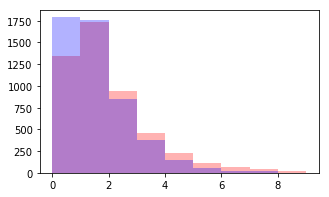

In [38]:
fig, ax = plt.subplots(figsize=(5,3))
bins = np.arange(0, 10,1)
ax.hist(gap_data, bins=bins, color='red', alpha=0.3)
ax.hist(gap_result, bins=bins, color='blue', alpha=0.3)

### make shuffle source file

In [ ]:
def shuffle(df, gap_data, gap_gen):
    """
    shuffle according to the distance
    Input:
        df - unlistyfied producer dataframe
        gap_data - gap list from data
        gap_gen - gap list from generated data
    Output: 
        df_new - unlistyfied producer dataframe
    """
    df = df.copy(deep=True)
    df_distance = find_distances(gap_data, gap_gen)
    maxP, maxD = find_max_distance(df_distance)
    if maxD < 0:
        df_new = shuffle_negative(df, maxP)
    if maxD >= 0:
        df_new = shuffle_positive(df, maxP)
    return df_physician_new

In [53]:
m = 'tt0099622'
p = 'RR501988'
unlistyfied_result_df[unlistyfied_result_df['_id'] == m].producers.tolist()
df = unlistyfied_result_df.copy(deep=True)
maxP = max_p

In [95]:
def shuffle_negative(df, maxP):
    """
    Shuffle the cases when the max distance is negative
    Probability of the gap for generated data > real data
    Input:
        df - unlistyfied producer schedules
        maxP - float, the point of the maximum distance between to data
    Output:
        df_new - DataFrame shuffled
    """
    df_new = df.copy(deep=True)

    df_match = find_max_distance_gaps(df_new, maxP)

    if len(df_match) >= 2:
        # print('From samples')
        movie1, movie2, producer1, producer2, p_list1, p_list2 = pick_producers(df_match)
        counter = 0
        while (producer1 in p_list2) or (producer2 in p_list1): #if producer1 and producer2's movies overlap
            # print('\t Still choosing from the samples', samples)
            movie1, movie2, producer1, producer2, p_list1, p_list2 = pick_producers(df_match)
            counter += 1
            if counter > 100: #if while goes too long, break
                # print('\t Switching to random')
                movie1, movie2, producer1, producer2, p_list1, p_list2 = pick_producers(df_new)
    else: #if the doctors in df_atch is less than 2 pick random doctors
        # print('Random')
        movie1, movie2, producer1, producer2, p_list1, p_list2 = pick_producers(df_new)

    #swap
    df_new.loc[(df_new._id == movie1) & (df_new.producers == producer1), 'producers'] = producer2
    df_new.loc[(df_new._id == movie2) & (df_new.producers == producer2), 'producers'] = producer1

    return df_new


In [90]:
def pick_producers(df_match, n=2):
    """
    pick producers to switch, condition - cannot be in the same movie
    """
    samples = df_match.sample(n=n)
    print(samples)
    #choose random shifts with max distance gap
    movie1, movie2 = samples._id
    producer1, producer2 = samples.producers
    p_list1 = df_new['producers'][df['_id'] == movie1].tolist()
    p_list2 = df_new['producers'][df['_id'] == movie2].tolist()
    return movie1, movie2, producer1, producer2, p_list1, p_list2

In [ ]:
def shuffle_positive(dfPhysician, maxP, docType, shift_type):
    """
    Shuffle the cases when the max distance is positive
    Probability of the gap for generated data < real data
    Input:
        dfPhysician - DataFrame of Physician schedule
        maxP - float, the point of the maximum distance between to data
        docType - string 'Fellow', 'Attending'
    Output:
        dfPhysicianNew - DataFrame shuffled
    """
    dfPhysicianNew = copy(dfPhysician)
    if shift_type == 'week':
        dfPhysicianNew = dfPhysicianNew[dfPhysicianNew['Days'] == 5]
    if shift_type == 'wkend':
        dfPhysicianNew = dfPhysicianNew[dfPhysicianNew['Days'] == 2]

    dfMatch = find_max_distance_gaps(dfPhysicianNew,maxP,docType)
    zeroShifts = []
    #Pick the first shifts that match (which is excluded in find_max_distance_gaps)
    for doc in dfMatch[docType].unique().tolist():
        firstIndex = dfMatch[dfMatch[docType]==doc].index.tolist()[0]
        firstDate = dfMatch['Date'][firstIndex]
        zeroShift = dfPhysicianNew[(dfPhysicianNew['Date'] == firstDate - pd.Timedelta(weeks=maxP+1)) 
                                   & (dfPhysicianNew[docType]==doc)].index.values.tolist()
        zeroShifts += zeroShift 

    excluded = dfMatch.index.tolist() + zeroShifts
    samples = [i for i in dfPhysicianNew.index.tolist() if i not in excluded]
    shiftNorm = random.choice(samples)
    docTarget = copy(dfPhysicianNew[docType][shiftNorm]) #doctor we are targeting to change
    date1 = copy(dfPhysicianNew['Date'][shiftNorm]) + pd.Timedelta(weeks=maxP+1)
    doctors1 = dfPhysicianNew[docType][dfPhysicianNew['Date']==date1].values.tolist() #doctors in the target date
    #Target doctors' all shifts that is not the shiftNorm
    #Choose Only if the shifts don't have the maxP
    docShifts = [s for s in dfPhysicianNew[dfPhysicianNew[docType]==docTarget].index.tolist() if s != shiftNorm and s in samples]
    random.shuffle(docShifts)
    for i in docShifts:
        date2 = dfPhysicianNew['Date'][i]
        doctors2 = dfPhysicianNew[docType][dfPhysicianNew['Date'] == date2].values.tolist()
        overlappingDocs = list(set(doctors1) - set(doctors2))
        if overlappingDocs:
            #Only if the shifts don't have have the maxP
            uniqueShifts = dfPhysicianNew[(dfPhysicianNew['Date'] == date1) & dfPhysicianNew.index.isin(samples)].index.tolist()
            if uniqueShifts:
                shift1 = random.choice(uniqueShifts)
                docChange = dfPhysicianNew[docType][shift1]
                shift1 = dfPhysicianNew[(dfPhysicianNew[docType] == docChange) & (dfPhysicianNew['Date'] == date1)].index.tolist()[0] 
                shift2 = dfPhysicianNew[(dfPhysicianNew[docType] == docTarget) & (dfPhysicianNew['Date'] == date2)].index.tolist()[0]
                dfPhysicianNew.loc[shift1, docType] = docTarget
                dfPhysicianNew.loc[shift2, docType] = docChange
                break
    
    return dfPhysicianNew


### Make dataframe with the exact team sizes

In [ ]:
data_dir = '/home/projects/movie-network/data/synthetic_data/model_3_0/'
gender_dir = '/home/projects/movie-network/data/synthetic_data/genders/'

In [ ]:
num_schedules = 1
version_list = net_gen.make_version(num_schedules)

In [ ]:
for key,value in sorted(gap_dict_per_producer.items(),key=lambda i:(sum(i[1]), len(i[1])),reverse=True):
    print(key, value, sum(value))

In [ ]:
total_movie_frame.head()

In [ ]:
shift_dist = []
# for v in range(num_schedules):


#generate new producers every round
generated_producers = net_gen.generate_producers(total_num_producers)
generated_producers_dict = {}
generated_producers_dict['female'] = generated_producers[:len(seeds)]
generated_producers_dict['male'] = generated_producers[len(seeds):]
total_movie_frame = movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True)
print('iterate years')
for year, df in total_movie_frame.groupby('year'):
    num_producers = number_of_producers_per_year[year] #duplicate producers are already dropped
    mean_size = np.mean(df.producer_num.tolist())
    mean_ceil = np.ceil(mean_size)
    mean_floor = np.floor(mean_size)
    #fix the team size to its mean
    df['producer_num'] = df.producer_num.apply(team_size, args=(mean_ceil, mean_floor))
    total_movie_frame['producer_num'].update(df.producer_num)
total_movie_frame['producers'] = np.nan
print('generate movies')
total_num_teams = total_movie_frame.producer_num.sum()
dict_movies = generate_movie_num(total_num_teams, generated_producers_dict, movie_per_producer_gender)
shift_dist.append(list(dict_movies.values()))
print('distribute movies')


    
for i, row in total_movie_frame.iterrows():
    producers, occurence = zip(*dict_movies.items())
    producers = np.array(producers)
    occurence = np.array(occurence)
    size = row.producer_num
    team = np.random.choice(producers, size, replace=False, p=occurence/sum(occurence))
    #assign list to cell
    total_movie_frame['producers'] = total_movie_frame['producers'].astype(object)
    total_movie_frame.at[i, 'producers'] = team
    for p in team:
        dict_movies[p] -= 1
        if dict_movies[p] == 0:
            del dict_movies[p]
            
            
            
#     total_movie_frame.to_json(os.path.join(data_dir, 'movies_3_0_{}.json'.format(version_list[v])), orient='split')
#     #save gender
#     generated_gender_df = pd.DataFrame(columns=['producer_id', 'gender'])
#     for g, producers in generated_producers_dict.items():
#         genders = [g for ii in producers]
#         appending_df = pd.DataFrame({'producer_id': producers, 'gender': genders})
#         generated_gender_df = generated_gender_df.append(appending_df)
#     generated_gender_df.to_json(os.path.join(gender_dir, 'movies_3_0', 'version_{}.json'.format(version_list[v])), orient='split')

In [ ]:
p_list = list(set([i for sublist in total_movie_frame.producers.tolist() for i in sublist]))

In [ ]:
for l in shift_dist:
    print(ks_2samp(l, movie_per_producer_gender['male']+movie_per_producer_gender['female']))

# Model 2-1

fixed number of movies, fixed number of producers

team size sampled from the real schedule

## Fill in producers

In [ ]:
num_schedules = 10

version_list = []
while len(version_list) < num_schedules:
    ver = make_version()
    if ver not in version_list:
        version_list.append(ver)

In [ ]:
from os import listdir
from os.path import isfile, join

original_file_list = [join(original_dir, f) for f in listdir(original_dir) 
                       if isfile(join(original_dir, f))]

## Concat over multiple years

In [ ]:
movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True).head()

In [ ]:
data_dir = '/home/projects/movie-network/data/synthetic_data/model_2_1/'

shift_dist = []
for v in range(num_schedules):
    #generate new producers every round
    generated_producers = net_gen.generate_producers(total_num_producers)
    generated_producers_dict = {}
    generated_producers_dict['female'] = generated_producers[:len(seeds)]
    generated_producers_dict['male'] = generated_producers[len(seeds):]
    total_movie_frame = movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True)
    total_movie_frame['producers'] = np.nan
    print('generate movies')
    total_num_teams = total_movie_frame.producer_num.sum()
    dict_movies = generate_movie_num(total_num_teams, generated_producers_dict, movie_per_producer_gender)
    shift_dist.append(list(dict_movies.values()))
    print('distribute movies')
    for i, row in total_movie_frame.iterrows():
        producers, occurence = zip(*dict_movies.items())
        producers = np.array(producers)
        occurence = np.array(occurence)
        size = row.producer_num
        team = np.random.choice(producers, size, replace=False, p=occurence/sum(occurence))
        total_movie_frame['producers'] = total_movie_frame['producers'].astype(object)
        total_movie_frame.at[i, 'producers'] = team
        for p in team:
            dict_movies[p] -= 1
            if dict_movies[p] == 0:
                del dict_movies[p]
    total_movie_frame.to_json(os.path.join(data_dir, 'movies_2_1_{}.json'.format(version_list[v])), orient='split')
    #save gender
    generated_gender_df = pd.DataFrame(columns=['producer_id', 'gender'])
    for g, producers in generated_producers_dict.items():
        genders = [g for ii in producers]
        appending_df = pd.DataFrame({'producer_id': producers, 'gender': genders})
        generated_gender_df = generated_gender_df.append(appending_df)
    generated_gender_df.to_json(os.path.join(gender_dir, 'movies_2_1', 'version_{}.json'.format(version_list[v])), orient='split')

In [ ]:
for l in shift_dist:
    print(ks_2samp(l, movie_per_producer_gender['male']+movie_per_producer_gender['female']))

# Problem

Random sampling does not account for all of the producers

In [ ]:
ver

In [ ]:
from os.path import normpath, basename, join, isfile
from os import listdir

In [ ]:
network_model =  basename(normpath(data_dir))
gender_folder = os.path.join('/home/projects/movie-network/data/synthetic_data/genders/', network_model)

In [ ]:
gender_file = [join(gender_folder, f) for f in listdir(gender_folder) if isfile(join(gender_folder, f)) and ver in f]

In [ ]:
if len(gender_file) == 1:
    gender_file = gender_file[0]
else:
    raise IndexError('the version has duplicate or it does not exist')

In [ ]:
df_gender = pd.read_json(gender_file, orient='split')
seeds = df_gender[df_gender.gender=='female'].producer_id.tolist()

In [ ]:
len(seeds)

In [ ]:
from os.path import dirname, realpath
two_up = dirname(dirname(__file__))

In [ ]:
os.path.abspath(os.path.join(data_dir, os.pardir, 'gender'))

In [ ]:
data_dir